In [892]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import vectorbt as vbt
import warnings
from scipy import stats
from itertools import product
import matplotlib.pyplot as plt
pd.set_option("future.no_silent_downcasting", True)

FREQ = "1D"

In [893]:
TICKER = 'BTC-USD'
START_DATE = '2019-01-01'

stock_data = yf.download(TICKER, start=START_DATE, interval='1d')

warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

def select_close_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Close', ticker) in df.columns:
            s = df[('Close', ticker)]
        else:
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        s = df['Close']
    return s.astype(float).squeeze()

close = select_close_series(stock_data, TICKER)
close.name = 'price'

TRAIN_RATIO = 0.7
split_idx = int(len(close) * TRAIN_RATIO)
train_close = close.iloc[:split_idx].copy()
val_close   = close.iloc[split_idx:].copy()

print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")

[*********************100%***********************]  1 of 1 completed

Data ready: train=2019-01-01 → 2023-11-03 | val=2023-11-04 → 2025-12-02


In [894]:
def select_high_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('High', ticker) in df.columns:
            s = df[('High', ticker)]
        else:
            cols = [c for c in df.columns if 'High' in str(c)]
            if not cols:
                raise KeyError("High not found")
            s = df[cols[0]]
    else:
        s = df['High']
    return s.astype(float).squeeze()

def select_low_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Low', ticker) in df.columns:
            s = df[('Low', ticker)]
        else:
            cols = [c for c in df.columns if 'Low' in str(c)]
            if not cols:
                raise KeyError("Low not found")
            s = df[cols[0]]
    else:
        s = df['Low']
    return s.astype(float).squeeze()

def select_volume_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Volume', ticker) in df.columns:
            s = df[('Volume', ticker)]
        else:
            cols = [c for c in df.columns if 'Volume' in str(c)]
            if not cols:
                raise KeyError("Volume not found")
            s = df[cols[0]]
    else:
        s = df['Volume']
    return s.astype(float).squeeze()

high  = select_high_series(stock_data, TICKER)
high.name = 'price'
low   = select_low_series(stock_data, TICKER)
low.name = 'price'
vol   = select_volume_series(stock_data, TICKER)
vol.name = 'price'

train_high = high.iloc[:split_idx].copy()
val_high   = high.iloc[split_idx:].copy()

train_low = low.iloc[:split_idx].copy()
val_low   = low.iloc[split_idx:].copy()

train_vol = vol.iloc[:split_idx].copy()
val_vol   = vol.iloc[split_idx:].copy()

### EMA

In [895]:
def ema_signals(close, period):
    ema = vbt.MA.run(close, period, ewm=True).ma

    entries = close.vbt.crossed_above(ema)   # Go long when price crosses above EMA
    exits   = close.vbt.crossed_below(ema)   # Exit long / enter short when price crosses below EMA

    # Shift signals forward by 1 bar (avoid lookahead bias)
    entries = np.roll(entries.values, 1); entries[0] = False
    exits   = np.roll(exits.values, 1);   exits[0] = False

    return entries, exits
ema_periods = list(range(37, 201, 1))

In [896]:
results = []

for p in ema_periods:
    entries, exits = ema_signals(train_close, p)

    pf = vbt.Portfolio.from_signals(
        train_close.values, entries, exits,
        # short_entries=exits, short_exits=entries,
init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D')

    results.append({
        'period': p,
        'total_return': pf.total_return(),
        'annualized_return': pf.annualized_return(freq='D'),
        'sharpe': pf.sharpe_ratio(freq='D'),
        'max_dd': pf.max_drawdown()
    })

gs_best = pd.DataFrame(results).sort_values('sharpe', ascending=False)
best_period = gs_best['period'].iloc[0]

In [897]:
entries, exits = ema_signals(train_close, best_period)
signal_ema = entries.astype(int) - exits.astype(int)

entries_v, exits_v = ema_signals(val_close, best_period)
signal_ema_val = entries_v.astype(int) - exits_v.astype(int)
pf_val = vbt.Portfolio.from_signals(
    val_close.values,
    entries_v,
    exits_v,
    # short_entries=exits_v,
    # short_exits=entries_v,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq='D'
)

In [898]:
print("IN-SAMPLE BEST PARAMS:", best_period)
print("\nIN-SAMPLE:")
print(f"Total Return: {gs_best.iloc[0]['total_return']:.2%}")
print(f"Annualized Return: {gs_best.iloc[0]['annualized_return']:.2%}")
print(f"Sharpe Ratio: {gs_best.iloc[0]['sharpe']:.3f}")
print(f"Max Drawdown: {gs_best.iloc[0]['max_dd']:.2%}")

print("\nOUT-OF-SAMPLE:")
print(f"Total Return: {pf_val.total_return():.2%}")
print(f"Annualized Return: {pf_val.annualized_return(freq='D'):.2%}")
print(f"Sharpe Ratio: {pf_val.sharpe_ratio(freq='D'):.3f}")
print(f"Max Drawdown: {pf_val.max_drawdown():.2%}")

IN-SAMPLE BEST PARAMS: 37

IN-SAMPLE:
Total Return: 1678.77%
Annualized Return: 81.17%
Sharpe Ratio: 1.481
Max Drawdown: -57.30%

OUT-OF-SAMPLE:
Total Return: 87.31%
Annualized Return: 35.23%
Sharpe Ratio: 1.060
Max Drawdown: -23.08%


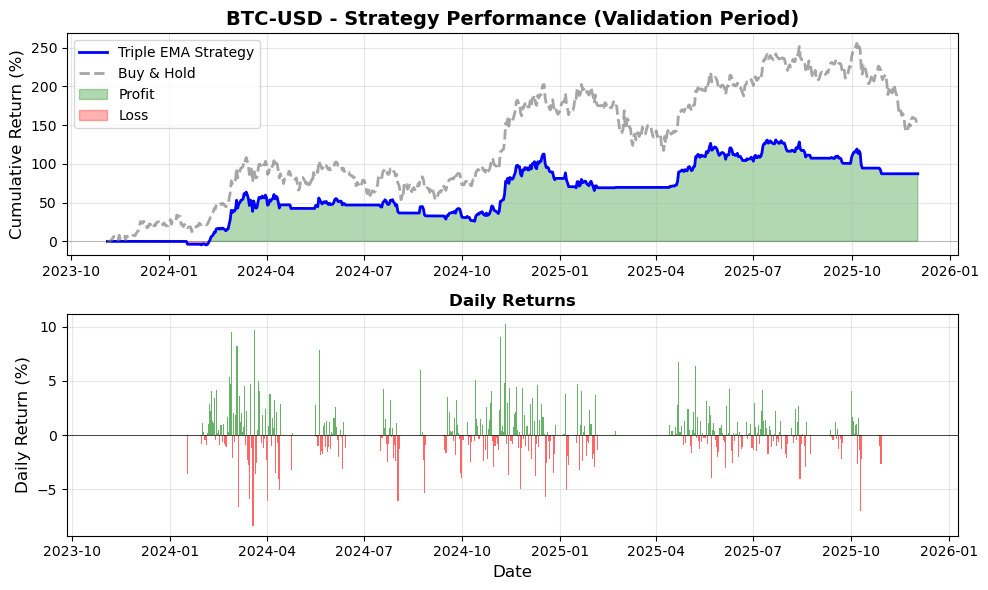

In [899]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

cumulative_returns = pf_val.cumulative_returns() * 100  # Convert to percentage
buy_hold_returns = (val_close / val_close.iloc[0] - 1) * 100  # Buy & Hold

ax1.plot(val_close.index, cumulative_returns, label='Triple EMA Strategy', 
         color='blue', linewidth=2)
ax1.plot(val_close.index, buy_hold_returns, label='Buy & Hold', 
         color='gray', linewidth=2, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns >= 0), alpha=0.3, color='green', label='Profit')
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns < 0), alpha=0.3, color='red', label='Loss')

ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
ax1.set_title(f'{TICKER} - Strategy Performance (Validation Period)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom plot: Daily returns
daily_returns = pf_val.returns() * 100
ax2.bar(val_close.index, daily_returns, color=['green' if r >= 0 else 'red' for r in daily_returns],
        alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### MACD

In [900]:
def macd_signals(close, fast=12, slow=26, signal=9):
    macd = vbt.indicators.MACD.run(close,
                                   fast_window=fast,
                                   slow_window=slow,
                                   signal_window=signal)
    entries = macd.macd.vbt.crossed_above(macd.signal).values
    exits   = macd.macd.vbt.crossed_below(macd.signal).values
    entries = np.roll(entries, 1); entries[0] = False
    exits   = np.roll(exits, 1); exits[0] = False
    return entries, exits

# macd_fast = list(range(5, 21, 2))
# macd_slow = list(range(20, 81, 3))
# macd_signal = list(range(3, 21, 2))
macd_fast = list(range(15, 17, 1))
macd_slow = list(range(60, 63, 1))
macd_signal = list(range(3, 5, 1))

In [901]:
# grid search
results = []
for fast, slow, signal in product(macd_fast, macd_slow, macd_signal):
    if fast < slow:
        entries, exits = macd_signals(train_close, fast=fast, slow=slow, signal=signal)
        pf = vbt.Portfolio.from_signals(train_close.values, entries, exits, 
                                        # short_entries=exits, short_exits=entries,
                                        init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D')
        results.append({
            'params': (fast, slow, signal),
            'total_return': pf.total_return(),
            'annualized_return': pf.annualized_return(freq='D'),
            'sharpe': pf.sharpe_ratio(freq='D'),
            'max_dd': pf.max_drawdown()
        })
gs_best = pd.DataFrame(results).sort_values('sharpe', ascending=False)

In [902]:
best_params = gs_best['params'].iloc[0]
entries, exits = macd_signals(train_close, *best_params)
signal_macd = entries.astype(int) - exits.astype(int)

entries_v, exits_v = macd_signals(val_close, *best_params)
signal_macd_val = entries_v.astype(int) - exits_v.astype(int)
pf_val = vbt.Portfolio.from_signals(
    val_close.values,
    entries_v, exits_v,
    init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D'
)

# pf_val = vbt.Portfolio.from_signals(
#     val_close.values,
#     entries_v,      # Long entries
#     exits_v,        # Long exits (which become short entries)
#     short_entries=exits_v,  # SHORT: Enter short when you exit long
#     short_exits=entries_v,   # SHORT: Exit short when you enter long
#     init_cash=100_000, 
#     fees=0.0005, 
#     slippage=0.0005, 
#     freq='D'
# )

In [903]:
print("IN-SAMPLE BEST PARAMS:", best_params)
print("\nIN-SAMPLE:")
print(f"Total Return: {gs_best.iloc[0]['total_return']:.2%}")
print(f"Annualized Return: {gs_best.iloc[0]['annualized_return']:.2%}")
print(f"Sharpe Ratio: {gs_best.iloc[0]['sharpe']:.3f}")
print(f"Max Drawdown: {gs_best.iloc[0]['max_dd']:.2%}")

print("\nOUT-OF-SAMPLE:")
print(f"Total Return: {pf_val.total_return():.2%}")
print(f"Annualized Return: {pf_val.annualized_return(freq='D'):.2%}")
print(f"Sharpe Ratio: {pf_val.sharpe_ratio(freq='D'):.3f}")
print(f"Max Drawdown: {pf_val.max_drawdown():.2%}")

IN-SAMPLE BEST PARAMS: (16, 62, 4)

IN-SAMPLE:
Total Return: 1735.65%
Annualized Return: 82.35%
Sharpe Ratio: 1.507
Max Drawdown: -52.30%

OUT-OF-SAMPLE:
Total Return: 115.68%
Annualized Return: 44.72%
Sharpe Ratio: 1.366
Max Drawdown: -21.55%


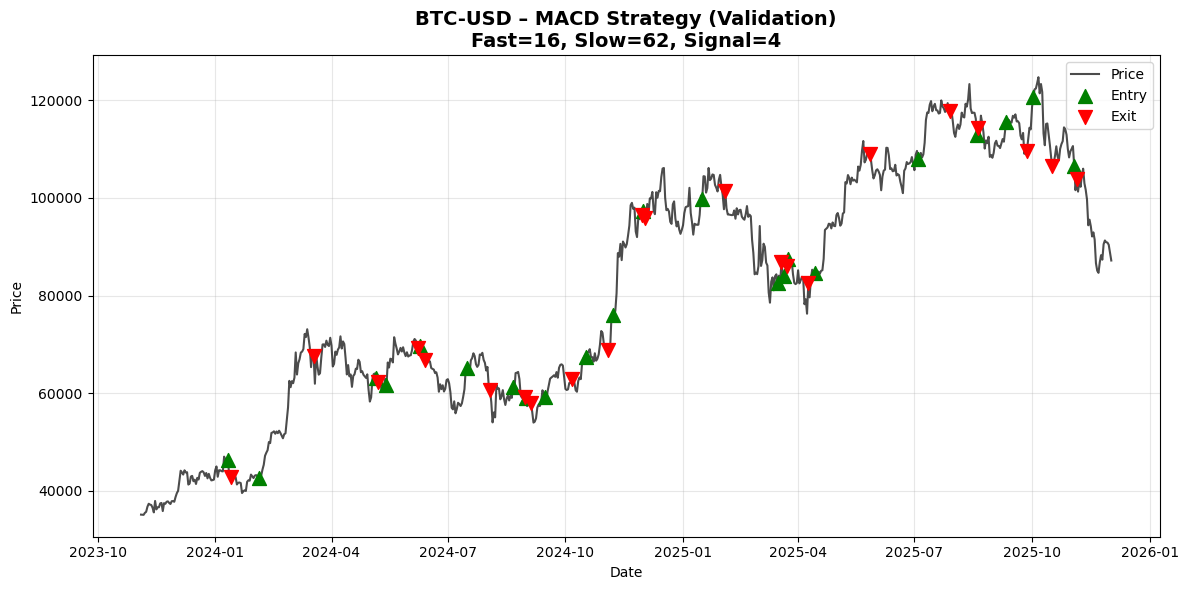

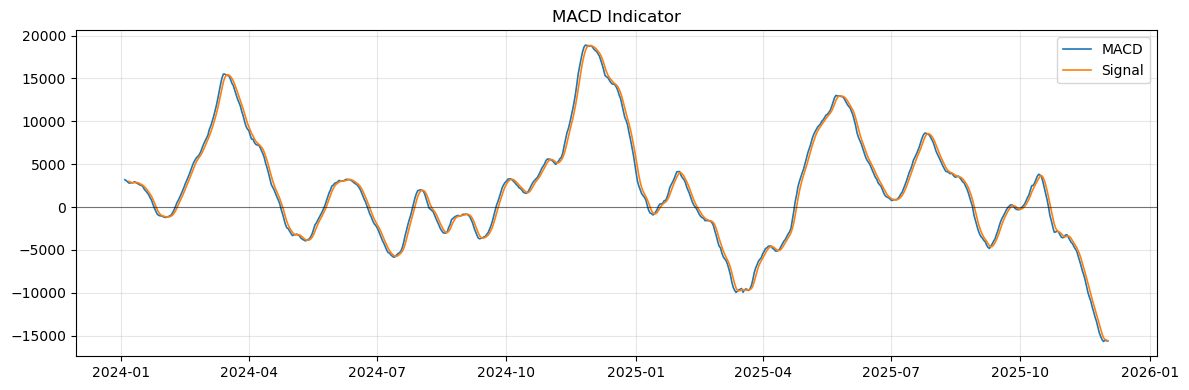

Best MACD Parameters: Fast=16, Slow=62, Signal=4
Number of Entries: 22
Number of Exits:   22


In [904]:
fast, slow, signal = best_params

macd_val = vbt.indicators.MACD.run(
    val_close,
    fast_window=fast,
    slow_window=slow,
    signal_window=signal
)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(val_close.index, val_close.values,
        label='Price', color='black', linewidth=1.5, alpha=0.7)

entry_dates = val_close.index[entries_v]
exit_dates  = val_close.index[exits_v]

ax.scatter(entry_dates, val_close.loc[entry_dates],
           marker='^', color='green', s=100, label='Entry', zorder=5)
ax.scatter(exit_dates, val_close.loc[exit_dates],
           marker='v', color='red', s=100, label='Exit', zorder=5)

ax.set_title(
    f"{TICKER} – MACD Strategy (Validation)\n"
    f"Fast={fast}, Slow={slow}, Signal={signal}",
    fontsize=14, fontweight='bold'
)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(macd_val.macd.index, macd_val.macd.values,
        label='MACD', linewidth=1.2)
ax.plot(macd_val.signal.index, macd_val.signal.values,
        label='Signal', linewidth=1.2)

ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)

ax.set_title("MACD Indicator")
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best MACD Parameters: Fast={fast}, Slow={slow}, Signal={signal}")
print(f"Number of Entries: {entries_v.sum()}")
print(f"Number of Exits:   {exits_v.sum()}")


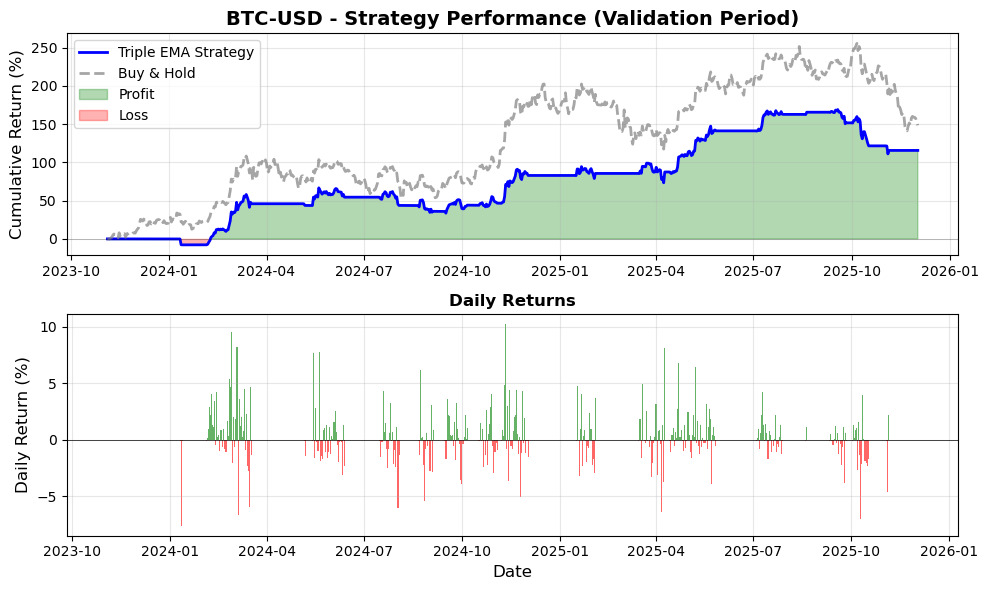

In [905]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Top plot: Cumulative returns comparison
cumulative_returns = pf_val.cumulative_returns() * 100  # Convert to percentage
buy_hold_returns = (val_close / val_close.iloc[0] - 1) * 100  # Buy & Hold strategy

ax1.plot(val_close.index, cumulative_returns, label='Triple EMA Strategy', 
         color='blue', linewidth=2)
ax1.plot(val_close.index, buy_hold_returns, label='Buy & Hold', 
         color='gray', linewidth=2, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns >= 0), alpha=0.3, color='green', label='Profit')
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns < 0), alpha=0.3, color='red', label='Loss')

ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
ax1.set_title(f'{TICKER} - Strategy Performance (Validation Period)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom plot: Daily returns
daily_returns = pf_val.returns() * 100  # Convert to percentage
ax2.bar(val_close.index, daily_returns, color=['green' if r >= 0 else 'red' for r in daily_returns],
        alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ATRvb

In [906]:
def atr_vol_breakout(high, low, close, period=14, k=2.0, trend_window=14):

    atr = vbt.ATR.run(high, low, close, window=period).atr
    prev_close = close.shift(1)

    upper_band = prev_close + k * atr
    lower_band = prev_close - k * atr

    # Long-term trend filter
    trend = vbt.MA.run(close, window=trend_window).ma
    uptrend = close > trend * 1

    # entries = (close > upper_band) & uptrend
    entries = high > upper_band
    exits = (close < trend) | (close < lower_band)

    return entries.values, exits.values

period = list(range(5, 51, 5))    # ATR periods: 5 → 50
k = [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0]
trend_window = [14, 30, 60, 90]

In [907]:
# grid search
results = []
for period, k, trend_window in product(period, k, trend_window):
    entries, exits = atr_vol_breakout(train_close, train_high, train_low, period, k, trend_window)
    pf = vbt.Portfolio.from_signals(train_close.values, entries, exits, 
                                    # short_entries=exits, short_exits=entries,
                                    init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D')
    if(pf.annualized_return(freq='D') <= 0): continue
    results.append({
        'params': (period, k, trend_window),
        'total_return': pf.total_return(),
        'annualized_return': pf.annualized_return(freq='D'),
        'sharpe': pf.sharpe_ratio(freq='D'),
        'max_dd': pf.max_drawdown()
    })
gs_best = pd.DataFrame(results).sort_values('annualized_return', ascending=False)

In [908]:
best_params = gs_best['params'].iloc[0]
entries, exits = atr_vol_breakout(train_close, train_high, train_low, *best_params)
signal_atr = entries.astype(int) - exits.astype(int)

entries_v, exits_v = atr_vol_breakout(val_close, val_high, val_low, *best_params)
signal_atr_val = entries_v.astype(int) - exits_v.astype(int)
pf_val = vbt.Portfolio.from_signals(
    val_close.values,
    entries_v, exits_v,
    init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D'
)

# pf_val = vbt.Portfolio.from_signals(
#     val_close.values,
#     entries_v,      # Long entries
#     exits_v,        # Long exits (which become short entries)
#     short_entries=exits_v,  # SHORT: Enter short when you exit long
#     short_exits=entries_v,   # SHORT: Exit short when you enter long
#     init_cash=100_000, 
#     fees=0.0005, 
#     slippage=0.0005, 
#     freq='D'
# )

In [909]:
print("IN-SAMPLE BEST PARAMS:", best_params)
print("\nIN-SAMPLE:")
print(f"Total Return: {gs_best.iloc[0]['total_return']:.2%}")
print(f"Annualized Return: {gs_best.iloc[0]['annualized_return']:.2%}")
print(f"Sharpe Ratio: {gs_best.iloc[0]['sharpe']:.3f}")
print(f"Max Drawdown: {gs_best.iloc[0]['max_dd']:.2%}")

print("\nOUT-OF-SAMPLE:")
print(f"Total Return: {pf_val.total_return():.2%}")
print(f"Annualized Return: {pf_val.annualized_return(freq='D'):.2%}")
print(f"Sharpe Ratio: {pf_val.sharpe_ratio(freq='D'):.3f}")
print(f"Max Drawdown: {pf_val.max_drawdown():.2%}")

IN-SAMPLE BEST PARAMS: (10, 2.0, 90)

IN-SAMPLE:
Total Return: 1628.20%
Annualized Return: 80.09%
Sharpe Ratio: 1.577
Max Drawdown: -27.19%

OUT-OF-SAMPLE:
Total Return: 122.51%
Annualized Return: 46.90%
Sharpe Ratio: 1.353
Max Drawdown: -17.20%


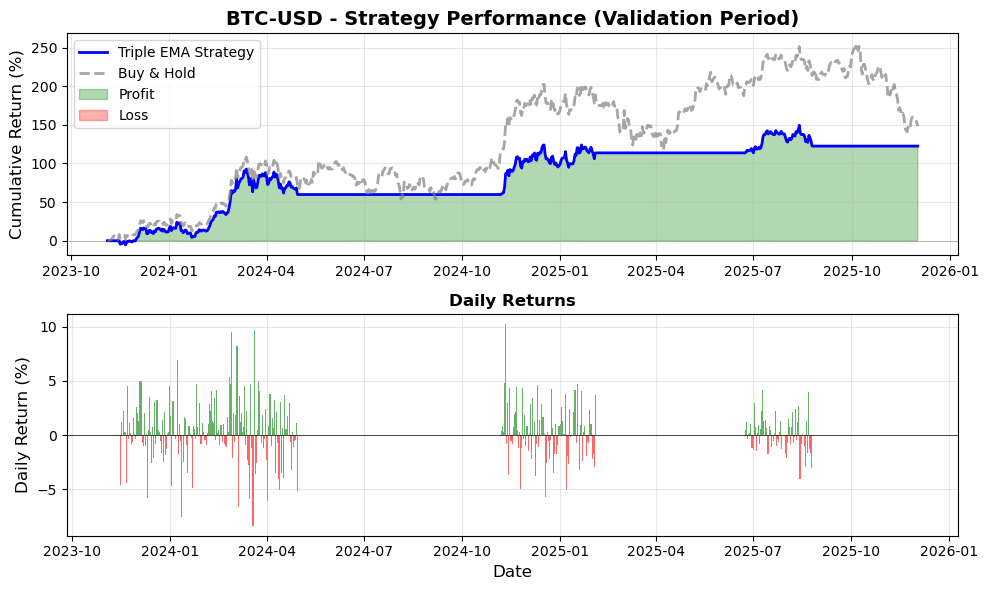

In [910]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Top plot: Cumulative returns comparison
cumulative_returns = pf_val.cumulative_returns() * 100  # Convert to percentage
buy_hold_returns = (val_close / val_close.iloc[0] - 1) * 100  # Buy & Hold strategy

ax1.plot(val_close.index, cumulative_returns, label='Triple EMA Strategy', 
         color='blue', linewidth=2)
ax1.plot(val_close.index, buy_hold_returns, label='Buy & Hold', 
         color='gray', linewidth=2, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns >= 0), alpha=0.3, color='green', label='Profit')
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns < 0), alpha=0.3, color='red', label='Loss')

ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
ax1.set_title(f'{TICKER} - Strategy Performance (Validation Period)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom plot: Daily returns
daily_returns = pf_val.returns() * 100  # Convert to percentage
ax2.bar(val_close.index, daily_returns, color=['green' if r >= 0 else 'red' for r in daily_returns],
        alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Combinaison

In [911]:
ind_signals = []
ind_signals = [signal_ema, signal_macd, signal_atr]
ind_signals = [np.array(s, dtype=float) for s in ind_signals]

ind_signals_val = []
ind_signals_val = [signal_ema_val, signal_macd_val, signal_atr_val]
ind_signals_val = [np.array(s, dtype=float) for s in ind_signals_val]

In [912]:
def combined_signal(weights, signals):
    combined = sum(weights[i] * signals[i] for i in range(len(weights)))
    entries = combined > 0
    exits   = combined < 0
    return entries, exits

In [913]:
def evaluate_weights_metrics(weights_int, signals, close):
    weights_decimal = weights_int / 100
    entries, exits = combined_signal(weights_decimal, signals)
    pf = vbt.Portfolio.from_signals(
        close,
        entries,
        exits,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq='D'
    )
    return {
        'sharpe': pf.sharpe_ratio(),
        'total_return': pf.total_return(),
        'annualized_return': pf.annualized_return(freq='D'),
        'max_dd': pf.max_drawdown()
    }

def random_int_weights(n, total=20):
    w = np.random.multinomial(total, [1/n]*n)
    return w * 4

In [914]:
best_w = None
best_metrics = None
best_sharpe = -np.inf

for _ in range(5000):
    w_int = random_int_weights(3)
    metrics = evaluate_weights_metrics(w_int, ind_signals, train_close)
    
    if metrics['sharpe'] > best_sharpe:
        best_sharpe = metrics['sharpe']
        best_w = w_int
        best_metrics = metrics

In [915]:
print("Best train weights:", best_w)
print("Metrics on train:")
print(f"Sharpe: {best_metrics['sharpe']:.3f}")
print(f"Total Return: {best_metrics['total_return']:.2%}")
print(f"Annualized Return: {best_metrics['annualized_return']:.2%}")
print(f"Max Drawdown: {best_metrics['max_dd']:.2%}")

Best train weights: [36 24 20]
Metrics on train:
Sharpe: 1.828
Total Return: 2033.12%
Annualized Return: 88.09%
Max Drawdown: -27.81%


In [916]:
entries_val, exits_val = combined_signal(best_w, ind_signals_val)
pf_val = vbt.Portfolio.from_signals(
    val_close,
    entries_val,
    exits_val,
    init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D'
)

In [917]:
print("OUT-OF-SAMPLE / Validation Metrics:")
print(f"Sharpe: {pf_val.sharpe_ratio(freq='D'):.3f}")
print(f"Total Return: {pf_val.total_return():.2%}")
print(f"Annualized Return: {pf_val.annualized_return(freq='D'):.2%}")
print(f"Max Drawdown: {pf_val.max_drawdown():.2%}")

OUT-OF-SAMPLE / Validation Metrics:
Sharpe: 1.132
Total Return: 88.58%
Annualized Return: 35.67%
Max Drawdown: -17.77%


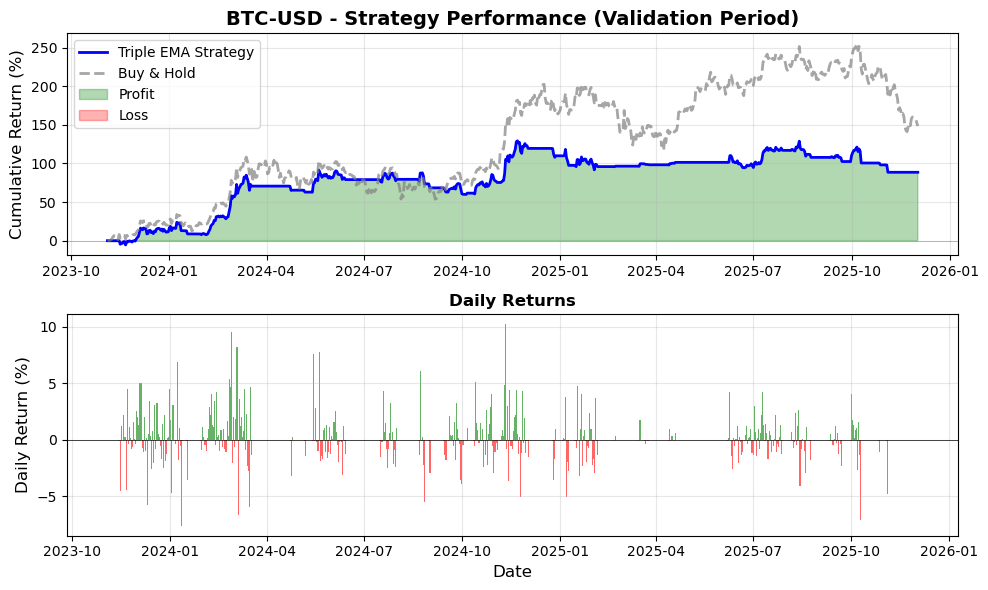

In [918]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

cumulative_returns = pf_val.cumulative_returns() * 100  # Convert to percentage
buy_hold_returns = (val_close / val_close.iloc[0] - 1) * 100  # Buy & Hold strategy

ax1.plot(val_close.index, cumulative_returns, label='Triple EMA Strategy', 
         color='blue', linewidth=2)
ax1.plot(val_close.index, buy_hold_returns, label='Buy & Hold', 
         color='gray', linewidth=2, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns >= 0), alpha=0.3, color='green', label='Profit')
ax1.fill_between(val_close.index, cumulative_returns, 0, 
                  where=(cumulative_returns < 0), alpha=0.3, color='red', label='Loss')

ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
ax1.set_title(f'{TICKER} - Strategy Performance (Validation Period)', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom plot: Daily returns
daily_returns = pf_val.returns() * 100  # Convert to percentage
ax2.bar(val_close.index, daily_returns, color=['green' if r >= 0 else 'red' for r in daily_returns],
        alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.set_title('Daily Returns', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()